In [43]:
import sys

from os.path import dirname, abspath
import os
sys.path.append(dirname(abspath(os.getcwd())))
import gymnasium as gym
import torch
import gym_usv
import numpy as np
from cleanrl.rpo_continuous_action import Agent
import matplotlib.pyplot as plt
from IPython.display import Video
import tempfile
from tqdm import tqdm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
#sns.set_theme()
import matplotlib
import matplotlib as mpl
from matplotlib.collections import EllipseCollection
from torch.distributions.normal import Normal

# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

In [44]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

envs = gym.vector.SyncVectorEnv(
        [make_env("usv-asmc-ca-v0", 0, False, "test_run", 0.99, (0, 0), (0, 0)) for i in range(1)]
    )

envs = gym.wrappers.ClipAction(envs)
envs = gym.wrappers.NormalizeObservation(envs)
envs = gym.wrappers.TransformObservation(envs, lambda obs: np.clip(obs, -10, 10))
envs = gym.wrappers.NormalizeReward(envs, gamma=0.99)
envs = gym.wrappers.TransformReward(envs, lambda reward: np.clip(reward, -10, 10))

max_y = 10
min_y = -10
max_x = 30
min_x = -10

/Users/abiel/mambaforge/envs/sb3/lib/python3.10/site-packages/gymnasium/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [50]:
agent = Agent(envs, 0.5)
agent_dict = torch.load('agent.pt', map_location=torch.device('cpu'))
agent.load_state_dict(torch.load('agent.pt', map_location=torch.device('cpu')), strict=False)
agent.eval()

envs.obs_rms.mean = np.average(agent_dict['obs_rms_mean'], axis=0)
envs.obs_rms.var = np.average(agent_dict['obs_rms_var'], axis=0)
envs.obs_rms.count = agent_dict['obs_rms_count']
#envs.envs[0].obs_rms.mean = agent_dict['obs_rms_mean'][0]
#envs.envs[0].obs_rms.var = agent_dict['obs_rms_var'][0]

In [46]:
def experiment_1_options():
    options = {}
    options['obs_x'] = np.array([10,5])
    options['obs_y'] = np.array([10,5])
    options['obs_r'] = np.array([5,2])
    options['start_position'] = np.array([0,0,0])
    options['target_point'] = np.array([9, 9, 0])
    options['renderplots'] = False
    return options

In [51]:
options = experiment_1_options()

next_obs, _ = envs.reset(seed=1)
next_obs = torch.Tensor(next_obs)
all_info = []

from gymnasium.wrappers.monitoring import video_recorder
recorder = video_recorder.VideoRecorder(
    envs.envs[0],
    "test_video.mp4"
)

for step in tqdm(range(1000)):
    with torch.no_grad():
        action, _, _, _ = agent.get_action_and_value(next_obs)
    
    state, reward, terminated, truncated, infos = envs.step(action.cpu().numpy())
    all_info.append(infos)
    done = np.logical_or(terminated, truncated)
    if done.all():
        break
    next_obs = torch.Tensor(state)
    recorder.capture_frame()

recorder.close()
Video("test_video.mp4")

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.48it/s]


Moviepy - Building video test_video.mp4.
Moviepy - Writing video test_video.mp4



Moviepy - Done !
Moviepy - video ready test_video.mp4


In [38]:
from collections import defaultdict
raw_data = defaultdict(list)
for info in all_info[:-2]:
    keys = all_info[0].keys()
    for key in keys:
        raw_data[key].append(info[key])

data = {}
concat_keys = ['position', 'velocity', 'action', 'action_in']
for key in concat_keys:
    data[key] = np.concatenate(raw_data[key])
    
for info in [a['asmc_info'] for a in all_info[:-2]]:
    d = info[0]
    for sub_d in d:
        for k, v in sub_d.items():
            raw_data[k].append(v)

asmc_data = {}
asmc_data['tstbd'] = raw_data['tstbd']
asmc_data['tport'] = raw_data['tport']
df_asmc = pd.DataFrame.from_dict(asmc_data)
df_asmc['time'] = df_asmc.index * 0.01

df = pd.DataFrame.from_dict(data)
df = pd.concat([df, pd.DataFrame(df['position'].to_list(), columns=['x','y','rot'])], axis=1)
df = pd.concat([df, pd.DataFrame(df['velocity'].to_list(), columns=['u','v','r'])], axis=1)
df = pd.concat([df, pd.DataFrame(df['action'].to_list(), columns=['action0', 'action1'])], axis=1)
df = pd.concat([df, pd.DataFrame(df['action_in'].to_list(), columns=['action_in0', 'action_in1'])], axis=1)

df['time'] = df.index * 0.1

df.describe()

obstacles = raw_data['obstacles'][0][0]
obstacle_radius = raw_data['obstacle_radius'][0][0]
target = raw_data['target'][0][0][:-1]
start_x, start_y, start_r = df['position'][0]

df.describe()

,x,y,rot,u,v,r,action0,action1,action_in0,action_in1,time
count,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,9.980000e+02,998.000000,998.0,998.000000
mean,4.874191,-10.210279,-44.562352,0.359064,0.068537,-0.972997,0.659908,-7.853982e-01,0.066055,-1.0,49.850000
std,0.458212,0.361001,29.589411,0.086565,0.007403,0.198262,0.122964,1.110780e-16,0.819762,0.0,28.824209
min,4.026439,-11.478766,-97.277170,0.004475,0.001363,-1.079817,0.500000,-7.853982e-01,-1.000000,-1.0,0.000000
25%,4.551915,-10.442875,-70.383847,0.327771,0.069386,-1.078970,0.501704,-7.853982e-01,-0.988643,-1.0,24.925000
50%,4.820145,-10.194764,-43.490525,0.327771,0.070914,-1.078970,0.679634,-7.853982e-01,0.197560,-1.0,49.850000
75%,5.050426,-9.945656,-17.117287,0.348310,0.070914,-0.958562,0.800000,-7.853982e-01,1.000000,-1.0,74.775000
max,6.599135,-9.312272,-0.208946,0.682799,0.071253,-0.053953,0.800000,-7.853982e-01,1.000000,-1.0,99.700000


/var/folders/vs/v598jthd5m394xwn82kr_xrr0000gn/T/ipykernel_20119/3205790591.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


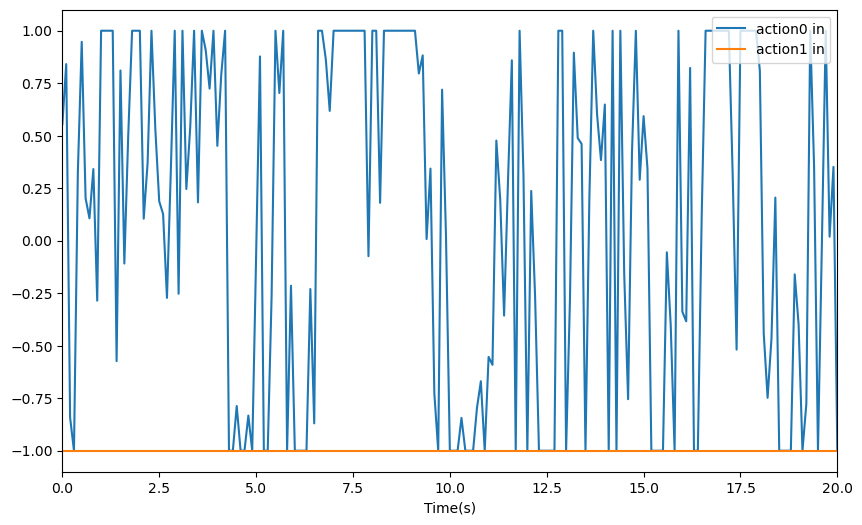

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(df.time, df['action_in0'], ls="-")
ax.plot(df.time, df['action_in1'], ls="-")
ax.legend(loc="upper right", labels=['action0 in', 'action1 in'])
#ax.set_title("Action")
ax.set_xlabel("Time(s)")
#plt.savefig('figures/action_plot.pgf')
ax.set_xlim(0, 20)

fig.show()

Text(0, 0.5, 'N')

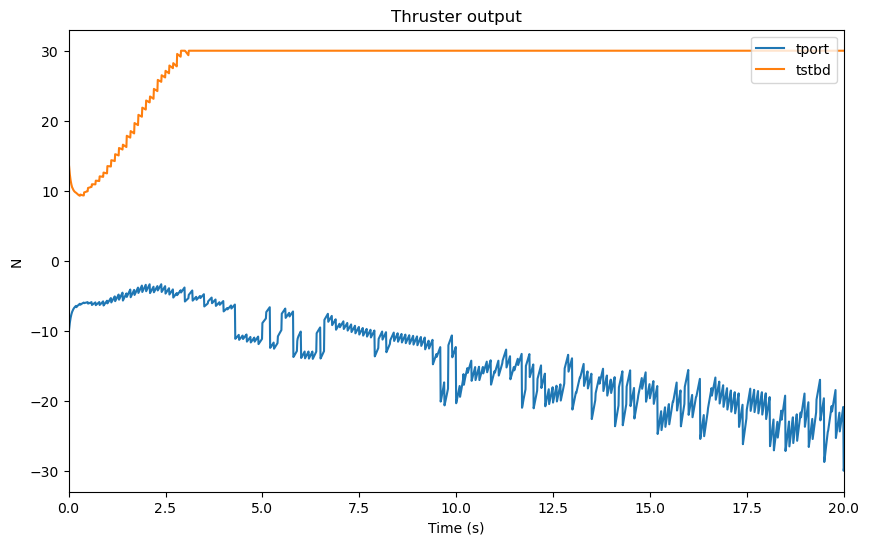

In [40]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(df_asmc.time, df_asmc['tport'], ls="-")
ax.plot(df_asmc.time, df_asmc['tstbd'], ls="-")
ax.legend(loc="upper right", labels=['tport', 'tstbd'])
ax.set_title("Thruster output")
ax.set_xlabel("Time (s)")
ax.set_xlim(0, 20)
ax.set_ylabel("N")

/var/folders/vs/v598jthd5m394xwn82kr_xrr0000gn/T/ipykernel_20119/3629702061.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


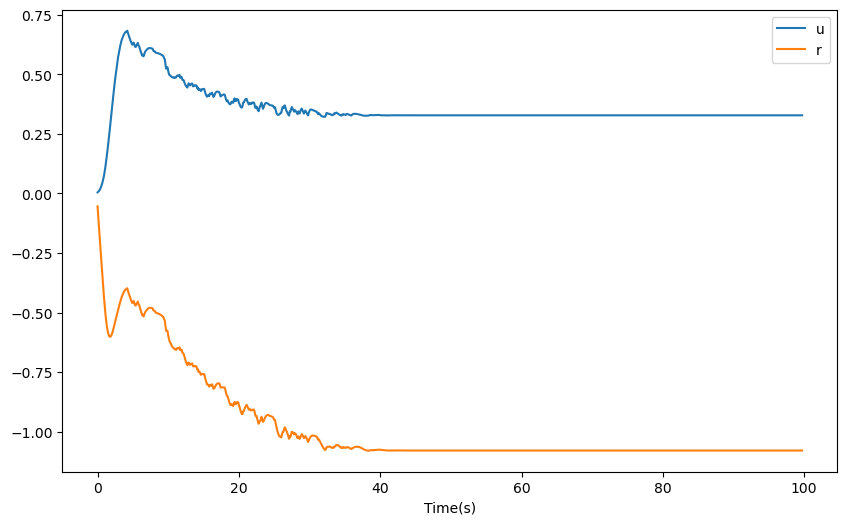

In [41]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(df.time, df['u'], ls="-")
ax.plot(df.time, df['r'], ls="-")
ax.legend(loc="upper right", labels=['u', 'r'])
#ax.set_title("Action")
ax.set_xlabel("Time(s)")
#plt.savefig('figures/action_plot.pgf')
fig.show()

/var/folders/vs/v598jthd5m394xwn82kr_xrr0000gn/T/ipykernel_20119/1950712198.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


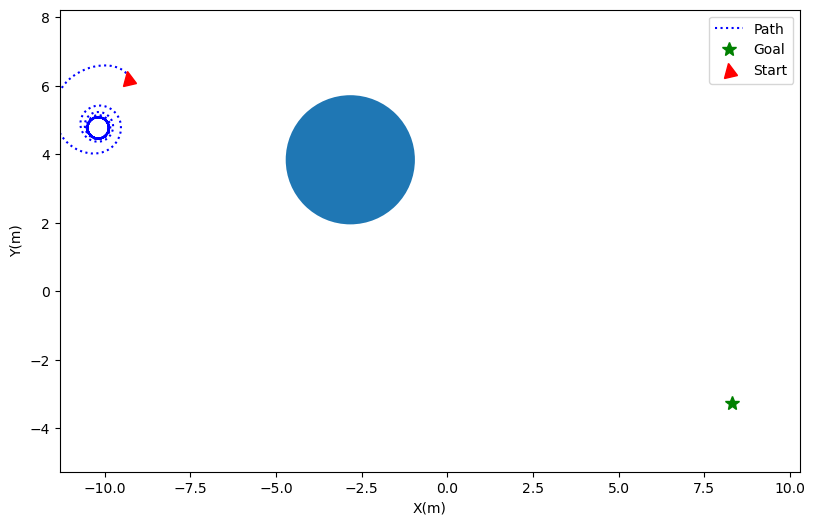

In [42]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
# map axis are swapped
ax.plot(df['y'], df['x'], 'b:', label="Path")
obstacles_rotated = obstacles.copy()
obstacles_rotated[:, 0], obstacles_rotated[:, 1] = obstacles_rotated[:, 1], obstacles_rotated[:, 0].copy()
ax.add_collection(EllipseCollection(widths=obstacle_radius*2, heights=obstacle_radius*2, angles=0, units='xy',
                                       offsets=obstacles_rotated, transOffset=ax.transData))
ax.plot(target[1], target[0], 'g*', label="Goal", markersize=10)

t = mpl.markers.MarkerStyle(marker='^')
t._transform = t.get_transform().rotate(-start_r)

ax.plot(start_y, start_x, 'r', label="Start", marker=t, markersize=10, linestyle='None')
ax.set_aspect(1)
ax.set_xlabel("X(m)")
ax.set_ylabel("Y(m)")


# Find new min and max limits
plt_min = min(start_x, target[0]), min(start_y, target[1])
plt_max = max(start_x, target[0]), max(start_y, target[1])

y_margin = 2
x_margin = 2
ax.set_aspect('equal')
ax.set_ylim(plt_min[0] - y_margin, plt_max[0] + y_margin)
ax.set_xlim(plt_min[1] - x_margin, plt_max[1] + x_margin)
ax.legend()
fig.show()